# Outlier identification

In [1]:
from pyod.models.knn import KNN
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from collections import Counter

In [1]:
%matplotlib inline

In [2]:
library(Seurat)
library(ggplot2)
library(cowplot)
library(SC3)

#Load the data
xenopus.combined <- readRDS(file = "xenopus_combined_and_clustered.rds")

Loading required package: scales

Warning message:
“Using `as.character()` on a quosure is deprecated as of rlang 0.3.0.
Please use `as_label()` or `as_name()` instead.
This warning is displayed once per session.”


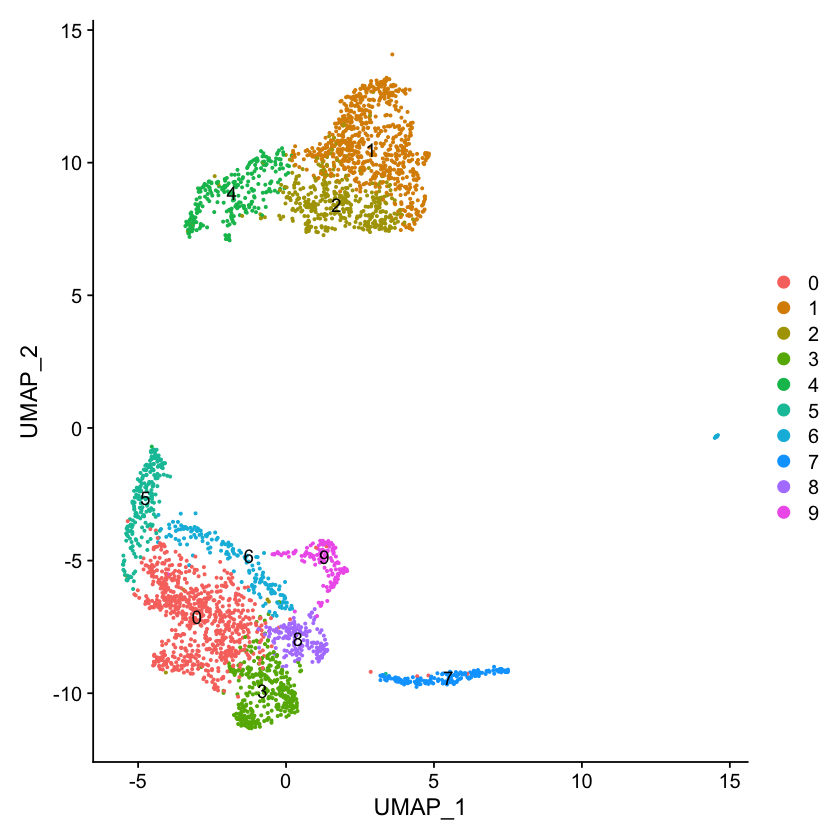

In [3]:
require(scales)

# Create vector of default ggplot2 colors
my_color_palette <- hue_pal()(11)[1:10]

DimPlot(xenopus.combined, reduction = "umap",cols=my_color_palette, label = TRUE)

# Automatic outlier identification

In [5]:
# Save the expression matrix for cluster 6 cells
xenopus.combined.cluster6 <- subset(xenopus.combined, idents=6)

HVGs <- rownames(xenopus.combined.cluster6)

DefaultAssay(xenopus.combined.cluster6) <- "integrated"

expmat.cluster6 <- as.data.frame(GetAssayData(object = xenopus.combined.cluster6))
metadata.cluster6 <- xenopus.combined.cluster6[[]]
umap.coords.cluster6 <- as.data.frame(Embeddings(xenopus.combined.cluster6,reduction='umap'))
umap.coords <- as.data.frame(Embeddings(xenopus.combined,reduction='umap'))
#xenopus.combined.cluster6.umap <- Embeddings(object = xenopus.combined.cluster6[["umap"]])

In [6]:
%get expmat.cluster6 --from R
%get metadata.cluster6 --from R
%get HVGs --from R
%get umap.coords.cluster6 --from R
%get umap.coords --from R
#%get xenopus.combined.cluster6.umap --from R

Variable expmat.cluster6 is put to SoS as expmat_cluster6
Loading required package: feather

Variable metadata.cluster6 is put to SoS as metadata_cluster6
Variable umap.coords.cluster6 is put to SoS as umap_coords_cluster6
Variable umap.coords is put to SoS as umap_coords


Counter({0: 163, 1: 14})


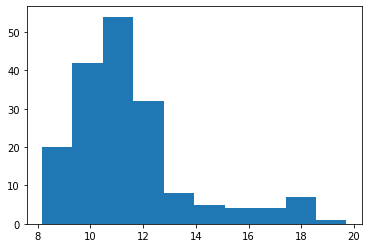

In [7]:
clf_name = 'KNN'
clf = KNN(n_neighbors=15,contamination=0.075)
clf.fit(expmat_cluster6.T)
plt.hist(clf.decision_scores_)
clf.threshold_
print(Counter(list(clf.labels_)))
out_labels=list(clf.labels_)

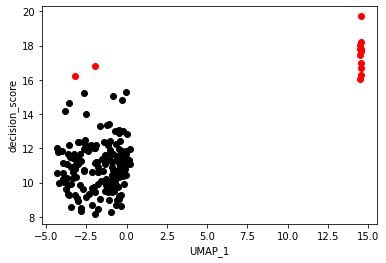

In [8]:
metadata_cluster6['umap1']=list(umap_coords_cluster6['UMAP_1'])
metadata_cluster6['scores']=clf.decision_scores_
metadata_cluster6['outliers']=out_labels

plt.figure()
plt.xlabel('UMAP_1')
plt.ylabel('decision_score')
for i in range(len(metadata_cluster6)):
    if metadata_cluster6['outliers'].iloc[i]==1:
        plt.scatter(metadata_cluster6['umap1'].iloc[i],metadata_cluster6['scores'].iloc[i],color='red')
    else:
        plt.scatter(metadata_cluster6['umap1'].iloc[i],metadata_cluster6['scores'].iloc[i],color='black')

14 outlier cells have been identified in cluster 6: 12 are those very far in the UMAP, 2 cells instead lie with the rest of cluster 6 in the UMAP.

## Exploration of the charcteristics of the outlier cells

We will check the correspondance between the distances from the cluster centroids in the low-dimensional (first 2 UMAP coordinates), high-dimensional (2000 genes used for UMAP computation and clustering) and the decision score used in the outlier detection algorithm.

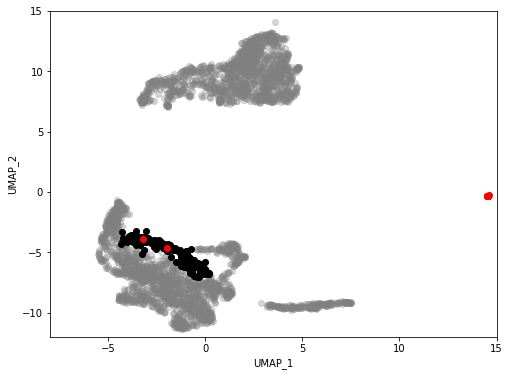

In [9]:
metadata_cluster6['umap2']=list(umap_coords_cluster6['UMAP_2'])

plt.figure(figsize=(8,6))
plt.xlim(-8,15)
plt.ylim(-12,15)
plt.xlabel('UMAP_1')
plt.ylabel('UMAP_2')
plt.scatter(umap_coords['UMAP_1'],umap_coords['UMAP_2'],color='grey',alpha=0.3)
for i in range(len(metadata_cluster6)):
    if metadata_cluster6['outliers'].iloc[i]!=1:
        plt.scatter(metadata_cluster6['umap1'].iloc[i],metadata_cluster6['umap2'].iloc[i],color='black')
#     else:
#         plt.scatter(metadata_cluster6['umap1'].iloc[i],metadata_cluster6['umap2'].iloc[i],color='black',
#                    alpha=0.3)
        
for i in range(len(metadata_cluster6)):
    if metadata_cluster6['outliers'].iloc[i]==1:
        plt.scatter(metadata_cluster6['umap1'].iloc[i],metadata_cluster6['umap2'].iloc[i],color='red')

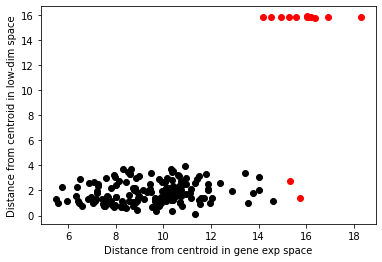

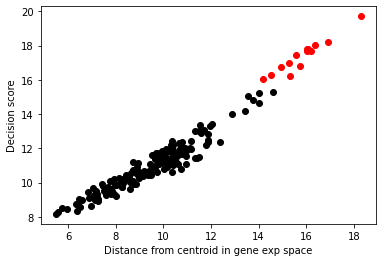

(None, None)

In [10]:
import pandas as pd
import numpy as np

# umap_coords=pd.DataFrame(data={'umap1':xenopus_combined_cluster6_umap[:,0],
#                               'umap2':xenopus_combined_cluster6_umap[:,1]},
#                          index=expmat_cluster6.columns)
# umap_coords=umap_coords.T
umap_coords_cluster6=umap_coords_cluster6.T
centroid_high_dim=expmat_cluster6.mean(axis=1)
centroid_low_dim=umap_coords_cluster6.mean(axis=1)
Euc_dist_high_dim=pd.DataFrame(index=expmat_cluster6.columns, 
                      data={'dist': [0.0]*len(expmat_cluster6.columns)})
Euc_dist_low_dim=pd.DataFrame(index=expmat_cluster6.columns, 
                      data={'dist': [0.0]*len(expmat_cluster6.columns)})

for i in range(len(expmat_cluster6.columns)):
    Euc_dist_high_dim.iloc[i]=np.linalg.norm(expmat_cluster6.iloc[:,i]-centroid_high_dim)
    Euc_dist_low_dim.iloc[i]=np.linalg.norm(umap_coords_cluster6.iloc[:,i]-centroid_low_dim)
    
plt.figure()
plt.xlabel('Distance from centroid in gene exp space')
plt.ylabel('Distance from centroid in low-dim space')
for i in range(len(metadata_cluster6)):
    if metadata_cluster6['outliers'].iloc[i]==1:
        plt.scatter(Euc_dist_high_dim.iloc[i],Euc_dist_low_dim.iloc[i],color='red')
    else:
        plt.scatter(Euc_dist_high_dim.iloc[i],Euc_dist_low_dim.iloc[i],color='black')
plt.show(),plt.close()

plt.figure()
plt.xlabel('Distance from centroid in gene exp space')
plt.ylabel('Decision score')
for i in range(len(metadata_cluster6)):
    if metadata_cluster6['outliers'].iloc[i]==1:
        plt.scatter(Euc_dist_high_dim.iloc[i],metadata_cluster6['scores'].iloc[i],color='red')
    else:
        plt.scatter(Euc_dist_high_dim.iloc[i],metadata_cluster6['scores'].iloc[i],color='black')
plt.show(),plt.close()

The 12 cells are sharply separated from the other 2 in UMAP space, but this sharp separation is not observed in gene-expression space.

The second plot clarifies why the 2 cells have been selected as outliers.

# Remove outliers and save raw and integrated data

In [18]:
new.cell.names <- setdiff(colnames(xenopus.combined),out_cell_names)

xenopus.combined.new <- subset(xenopus.combined, cells=new.cell.names)
xenopus.combined.raw.new <- subset(xenopus.combined.raw, cells=new.cell.names)

saveRDS(xenopus.combined.new, file = "scXeLaev.rds")
saveRDS(xenopus.combined.raw.new, file = "scXeLaev_raw.rds")

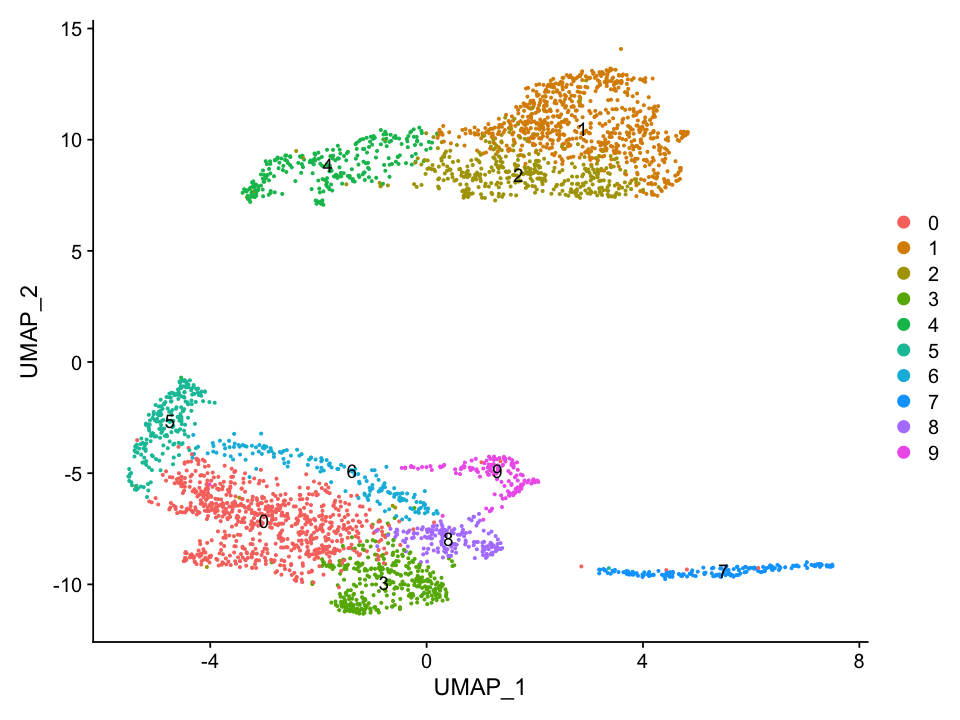

In [20]:
DimPlot(xenopus.combined.new, reduction = "umap",cols=my_color_palette, label = TRUE)

In [41]:
sessionInfo()

R version 3.5.2 (2018-12-20)
Platform: x86_64-apple-darwin15.6.0 (64-bit)
Running under: macOS Mojave 10.14.6

Matrix products: default
BLAS: /Library/Frameworks/R.framework/Versions/3.5/Resources/lib/libRblas.0.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/3.5/Resources/lib/libRlapack.dylib

locale:
[1] C/UTF-8/C/C/C/C

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] topGO_2.34.0                SparseM_1.78               
 [3] GO.db_3.7.0                 AnnotationDbi_1.44.0       
 [5] graph_1.60.0                dplyr_1.0.2                
 [7] scran_1.10.2                SingleCellExperiment_1.4.1 
 [9] DESeq2_1.22.2               SummarizedExperiment_1.12.0
[11] DelayedArray_0.8.0          BiocParallel_1.16.6        
[13] matrixStats_0.57.0          Biobase_2.42.0             
[15] GenomicRanges_1.34.0        GenomeInfoDb_1.18.2        
[17] IRanges_2.16.0             